In [1]:
import pandas as pd
import numpy as np
import time                     #python 自带
from astropy.time import Time   #astropy 
from astropy import units as u 
from astropy import constants as const #import constants 
from astropy.coordinates import cartesian_to_spherical
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS
import ligo.skymap.plot

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from moviepy.video.io.bindings import mplfig_to_npimage#动图生成
import moviepy.editor as mpy

####teukolsky
from lib.waveform import teukolsky
from lib.waveform import get_td_waveform

from scipy.interpolate import interp1d


# Constants
G = (const.G).value # gravitational constant
C = (const.c).value # the speed of light


def randUnitVec(number):
    phi      = np.random.rand(number,1) * 2 * np.pi  #方位角
    costheta = np.random.rand(number,1) * 2 - 1
    x = np.sqrt(1 - costheta**2) * np.cos(phi)
    y = np.sqrt(1 - costheta**2) * np.sin(phi)
    z = costheta
    r = np.concatenate([x, y, z], axis = 1)
    return r #(x,y,z)

def vecCross(a, b):
    e = np.zeros((3, 3, 3))
    e[0, 1, 2] = e[1, 2, 0] = e[2, 0, 1] = 1
    e[0, 2, 1] = e[2, 1, 0] = e[1, 0, 2] = -1

    c = [np.einsum("i,j,ijk->k", a[i,:],b[i,:], e) for i in range(0, len(a))]
    return np.vstack(c) #(x,y,z)

def vecDot(a, b):
    c = [np.inner(a[i],b[i]) for i in range(0, len(a))]
    return np.vstack(c) #(x,y,z)


def cart2spher(r):
    ans   =  cartesian_to_spherical(r[:,0], r[:,1], r[:,2])
    theta = ((np.pi/2 * u.radian - ans[1][0]) ).to('deg').value
    phi   = ans[2][0].to('deg').value
    return theta, phi


def transMat(ex, ey, ez):
    c = [np.vstack([ex[i], ey[i], ez[i]]) for i in range(0, len(ex))]
    return c


def W2ThetaPhi(trans, NVec):
    wt      = np.vstack([(np.inner(trans[i], NVec)).T for i in range(0, len(trans))])
    ewt     = wt / np.linalg.norm(wt, axis=1, keepdims=True)
    rLatLon = cartesian_to_spherical(ewt[:,0], ewt[:,1], ewt[:,2])
    theta   = np.pi/ 2 - rLatLon[1].value  #theta
    phi     = rLatLon[2].value # phi
    thetaPhi= np.vstack([theta, phi]).T
    return thetaPhi

def LNZ2Psi(LVec, NVec, ezd):
    psi = [np.arctan((vecDot(LVec, np.array([ezd[i]]) ) - vecDot(LVec, NVec) * vecDot(np.array([ezd[i]]), NVec)) \
                          / vecDot(NVec, vecCross(LVec, np.array([ezd[i]])))) for i in range(0, len(ezd))]
    return np.vstack(psi)


def Fplus1(theta, phi, psi):
    return 1/2 * (1 + (np.cos(theta))**2) * np.cos(2 * phi) * np.cos(2 * psi) \
- np.cos(theta)* np.sin(2 * phi) * np.sin(2 * psi) 

def Fcross1(theta, phi, psi):
    return 1/2 * (1 + (np.cos(theta))**2) * np.cos(2 * phi) * np.sin(2 * psi) \
+ np.cos(theta)* np.sin(2 * phi) * np.cos(2 * psi) 


def Fplus2(theta, phi, psi):
    return 1/2 * (1 + (np.cos(theta))**2) * np.sin(2 * phi) * np.cos(2 * psi) \
+ np.cos(theta)* np.cos(2 * phi) * np.sin(2 * psi) 

def Fcross2(theta, phi, psi):
    return 1/2 * (1 + (np.cos(theta))**2) * np.sin(2 * phi) * np.sin(2 * psi) \
- np.cos(theta)* np.cos(2 * phi) * np.cos(2 * psi) 



def WaveDataOut(**kwargs):
    #   Parameters
    duration = 86400 * 30          #信号持续时间(duration of signal) 2^16, 0.75d, 2^25 ,1.06yr
    step = 4

    atilde = np.sqrt(kwargs['SpinxBH']**2 + kwargs['SpinyBH']**2 + kwargs['SpinzBH']**2)  # 自旋参量
    nu = kwargs['MassCO'] / kwargs['MassBH'] # 质量比? 对称质量比
    M = ((kwargs['MassBH'] + kwargs['MassCO']) * const.M_sun).to(u.kg).value  #the mass of system, kilogram
    # m = (1e1 * const.M_sun).to(u.kg).value  #the mass of small compact body, kilogram

    l = np.arange(2,3)      
    # m = 2
    k = np.arange(-2,12,1)                   #the nth harmonic

    ########################
    R_unit = (G * M / C**2)#                #the unit length in G = C = 1 system, metre
    # t_unit = R_unit / C    #                #the unit time in G = C = 1 system, second
    ########################

    e = kwargs['ECC']                                 #eccentricity of orbit
    p = kwargs['PM']  * R_unit                         #semi-latus rectum

    a = p / (1 - e**2)                      #the semi-major axis of orbit, metre

    D = (1.00 * u.Gpc).to('m').value

    wave = teukolsky(atilde = atilde, nu = nu, M = M, l = l, k = k, e = e, a = a, D = D)
    wave.ecalculate(duration = duration, delta_t = step)
    hp, hc = get_td_waveform(template=wave)

    timeVec = (np.array(hp.sample_times)).reshape(-1, 1)
    hpVec =  (np.array(hp)).reshape(-1, 1)
    hcVec =  (np.array(hc)).reshape(-1, 1)
    waveMat = np.concatenate((timeVec, hpVec, hcVec), axis = 1)
    waveData = pd.DataFrame(waveMat, columns = ['timeSecond', 'hp', 'hc'])
#     waveData.to_csv('waveDataEMRI.dat')# columns=['JDTimeTCB']  #导出csv文件
    return waveData


In [2]:
orbitDataTAIJI  =  pd.read_csv('orbitData/orbitDataTAIJI.dat', index_col = 0)  #读取csv文件
orbitData      =  orbitDataTAIJI.loc[0:366,:]

sunPX = orbitData['sunPX']
sunPY = orbitData['sunPY']
sunPZ = orbitData['sunPZ']

earthPX = orbitData['earthPX']
earthPY = orbitData['earthPY']
earthPZ = orbitData['earthPZ']

scp1X = orbitData['scp1X']
scp1Y = orbitData['scp1Y']
scp1Z = orbitData['scp1Z']

scp2X = orbitData['scp2X']
scp2Y = orbitData['scp2Y']
scp2Z = orbitData['scp2Z']

scp3X = orbitData['scp3X']
scp3Y = orbitData['scp3Y']
scp3Z = orbitData['scp3Z']

scpX = (scp1X + scp2X + scp3X) / 3  
scpY = (scp1Y + scp2Y + scp3Y) / 3  
scpZ = (scp1Z + scp2Z + scp3Z) / 3  

scp = (np.vstack([scpX, scpY, scpZ])).T
scp1 = (np.vstack([scp1X, scp1Y, scp1Z])).T
scp2 = (np.vstack([scp2X, scp2Y, scp2Z])).T
scp3 = (np.vstack([scp3X, scp3Y, scp3Z])).T


d12 = scp2 - scp1 
d13 = scp3 - scp1
xd  = d12 + d13

ed12 = d12 / np.linalg.norm(d12, axis=1, keepdims=True)
ed13 = d13 / np.linalg.norm(d13, axis=1, keepdims=True)


exd = xd / np.linalg.norm(xd, axis=1, keepdims=True)
ezd = vecCross(ed13, ed12)
eyd = vecCross(ezd, exd)


trans = transMat(exd, eyd, ezd)


NVec = np.array([[-0.21754308, -0.88794532, -0.40525068]]) #randUnitVec(1)
LVec = NVec + np.array([[1e-13,1e-13,1e-13]])#randUnitVec(1)

LVec = LVec / np.linalg.norm(LVec, axis=1, keepdims=True)

print(NVec, LVec)

# vecDot(ezd,eyd)
# vecDot(exd,eyd)
# vecDot(ezd,exd)

[[-0.21754308 -0.88794532 -0.40525068]] [[-0.21754308036907616 -0.8879453215067659  -0.40525068068762077]]


In [3]:
thetaPhi = W2ThetaPhi(trans, NVec)
theta = thetaPhi[:,0]
phi = thetaPhi[:,1]
psi = LNZ2Psi(LVec, NVec, ezd)[:,0]

####
Fp1 = Fplus1(theta, phi, psi)
Fc1 =  Fcross1(theta, phi, psi)
Fp2 = Fplus2(theta, phi, psi)
Fc2 =  Fcross2(theta, phi, psi)

In [4]:
ans = np.vstack([Fp1, Fc1, Fp2, Fc2]).T
ans

array([[-0.5521315324433415 , -0.15030404945259607, -0.20878741561844705,
         0.39747606061789387],
       [-0.5590810809072442 , -0.15004875500516687, -0.2045761156707861 ,
         0.41006604536567565],
       [-0.5660404772768409 , -0.1496424006767888 , -0.2004448494654396 ,
         0.42257941532661986],
       ...,
       [-0.5337930469512191 , -0.15010479400127655, -0.22024150267657652,
         0.3638078352402124 ],
       [-0.5406583188175834 , -0.1503854424876785 , -0.21594792704627197,
         0.3765152757445382 ],
       [-0.5475424432985471 , -0.15047866827143222, -0.21171636692045329,
         0.38917117375460125]])

In [5]:
timeVec = orbitData['timeJD']

In [6]:
timeVecSec = (timeVec - 2461853.0) * 86400
fp1 =interp1d(timeVecSec, Fp1,kind='cubic')#三次样条插值
fc1 =interp1d(timeVecSec, Fc1,kind='cubic')#三次样条插值

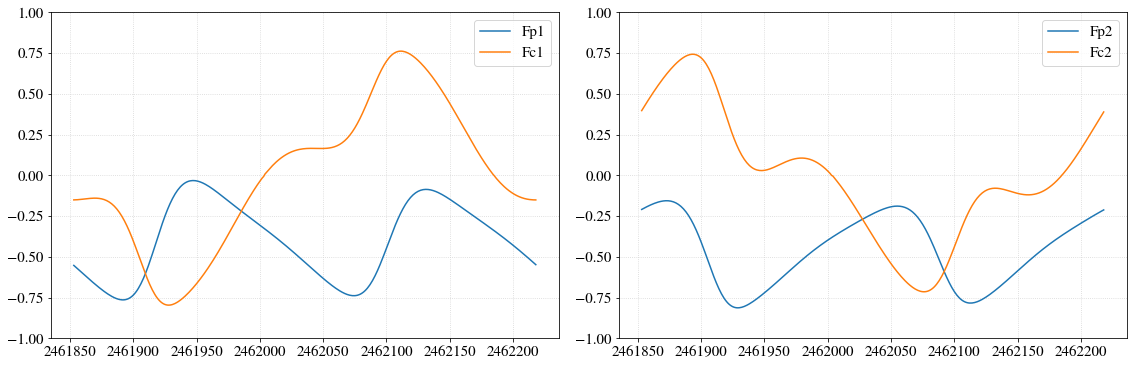

In [7]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

plt.figure(figsize=(16,8/1.5))
plt.subplot(121)
plt.plot(timeVec, Fp1, label='Fp1')
plt.plot(timeVec, Fc1, label='Fc1')
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")

plt.subplot(122)
plt.plot(timeVec, Fp2, label='Fp2')
plt.plot(timeVec, Fc2, label='Fc2')
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")

plt.show()

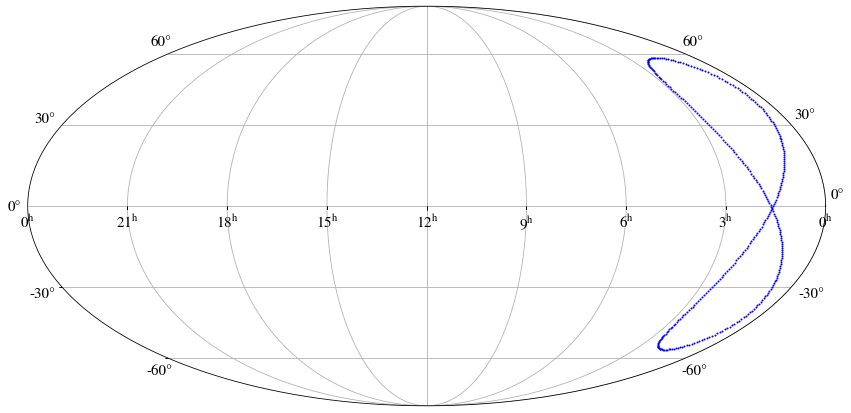

In [8]:

source= SkyCoord(phi , np.pi/2 - theta, unit="radian", frame = 'icrs')  # defaults to ICRS frame

matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
# 绘图
C_center = SkyCoord(8*np.pi/8 , -2*np.pi/8, unit="radian", frame = 'icrs')  # defaults to ICRS frame

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='astro hours mollweide')

ax.plot_coord(source,'o',c='blue',markersize=1)

ax.grid(ax)
plt.tight_layout()
plt.show()

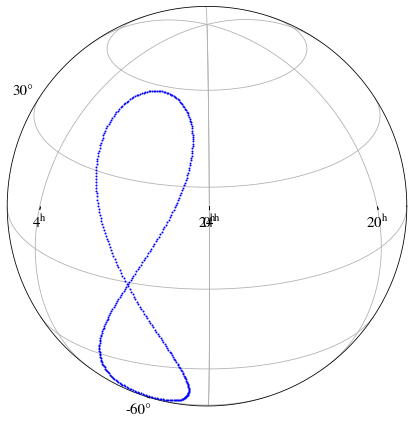

In [9]:

source= SkyCoord(phi , np.pi/2 - theta, unit="radian", frame = 'icrs')  # defaults to ICRS frame

matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
# 绘图

theta_mean = np.pi/2 - np.mean(theta)

phi_mean = np.mean(phi)
C_center = SkyCoord(theta_mean , phi_mean, unit="radian", frame = 'icrs')  # defaults to ICRS frame

fig = plt.figure(figsize=(12,6))
# ax = plt.axes(projection='astro hours mollweide')
ax = plt.axes(projection='astro globe', center= C_center)
ax.plot_coord(source,'o',c='blue',markersize=1)

ax.grid(ax)
plt.tight_layout()
plt.show()

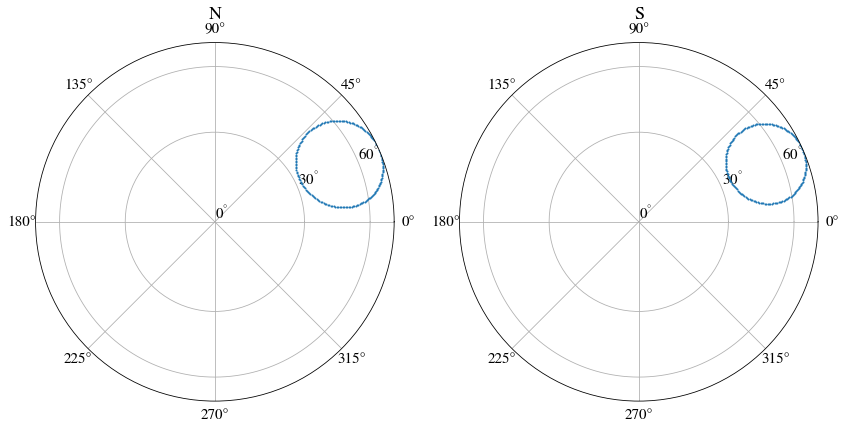

In [10]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
# 绘图


fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(121, projection='polar')
ax1.plot(phi[theta <= np.pi/2], np.sin(theta[theta <= np.pi/2]), 'o', markersize=1)
ax1.set_rgrids(np.sin([0, np.pi/6, np.pi/3]), labels = ['$0^{\degree}$', '$30^{\degree}$', '$60^{\degree}$'])
ax1.set_rlim(0,1)
ax1.set_title('N')


ax2 = plt.subplot(122, projection='polar')

ax2.set_rlim(0,1)
ax2.plot(phi[theta >= np.pi/2], np.sin(theta[theta >= np.pi/2]), 'o', markersize=1)
ax2.set_rgrids(np.sin([0, np.pi/6, np.pi/3]), labels = ['$0^{\degree}$', '$30^{\degree}$', '$60^{\degree}$'])
ax2.set_title('S')
# ax.plot_coord(source,'o',c='blue',markersize=1)

# ax.grid(ax)
plt.tight_layout()
plt.show()

In [11]:
MassBH    = 1e6
SpinxBH   = 0
SpinyBH   = 0
SpinzBH   = 0.9
MassCO    = 1e1
SpinxCO   = 0 
SpinyCO   = 0
SpinzCO   = 90
ECC       = 0.5
PM        = 20
IOTA      = 0.25


kwargs = dict(MassBH=MassBH, SpinxBH=SpinxBH, SpinyBH=SpinyBH, SpinzBH=SpinzBH, \
    MassCO=MassCO, SpinxCO=SpinxCO, SpinyCO=SpinyCO, SpinzCO=SpinzCO, ECC=ECC, PM=PM, IOTA=IOTA)

wave = WaveDataOut(**kwargs)
wave.to_csv('waveDataEMRIyear.dat')# columns=['JDTimeTCB']  #导出csv文件

evolution finished, cost 0.028s
omega_mk finished, cost341.768s
hlmk finished, cost 8.953s


In [12]:
data  =  wave
fp1Factor = fp1(data['timeSecond'])
fc1Factor = fc1(data['timeSecond'])
ht = np.sqrt(3)/2 * (fp1Factor * data['hp'] + fc1Factor * data['hc'])

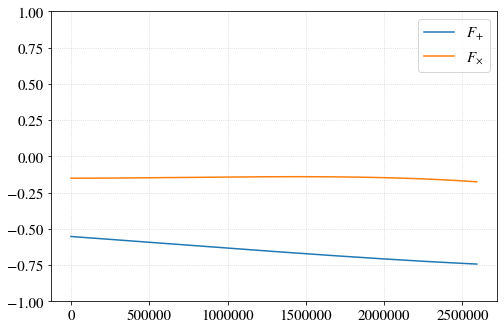

In [23]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

plt.figure(figsize=(8,8/1.5))
plt.plot(data['timeSecond'], fp1Factor, label='$F_{+}$')
plt.plot(data['timeSecond'], fc1Factor, label='$F_{\\times}$')
plt.ylim(-1, 1)
plt.legend(loc='best')
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")


plt.show()

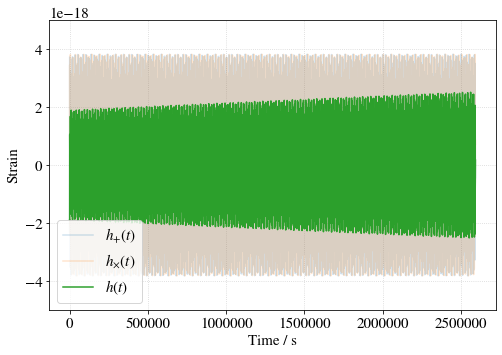

In [14]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

data  =  wave
plt.figure(figsize=(8, 8/1.5))
plt.plot(data['timeSecond'], data['hp'] ,label = '$h_{+}(t)$', alpha = 0.2)
plt.plot(data['timeSecond'], data['hc'], label = '$h_{\\times}(t)$', alpha = 0.2)
plt.plot(data['timeSecond'],  ht, label = '$h(t)$')
# plt.xlim(0,8e3)
plt.ylim(- 5e-18, 5e-18)
plt.xlabel("Time / s")
plt.ylabel("Strain")
plt.legend()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")


plt.show()

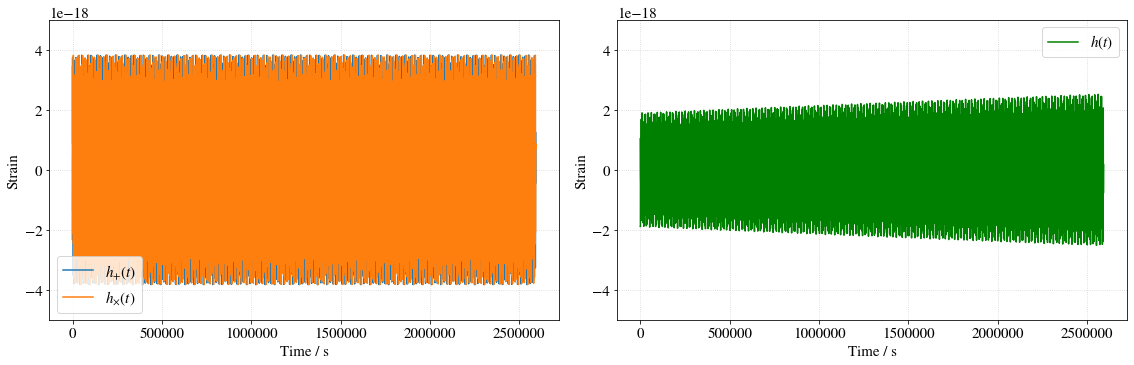

In [25]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

data  =  wave
plt.figure(figsize=(16, 8/1.5))
plt.subplot(121)
plt.plot(data['timeSecond'], data['hp'], label = '$h_{+}(t)$')
plt.plot(data['timeSecond'], data['hc'], label = '$h_{\\times}(t)$')
# plt.xlim(0,8e3)
plt.ylim(- 5e-18, 5e-18)
plt.xlabel("Time / s")+
plt.ylabel("Strain")
plt.legend()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")

plt.subplot(122)
plt.plot(data['timeSecond'],  ht, label = '$h(t)$', c='green')
# plt.xlim(0,8e3)
plt.ylim(- 5e-18, 5e-18)
plt.xlabel("Time / s")
plt.ylabel("Strain")
plt.legend()
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.show()